<div style="text-align: right">Peter Norvig, April 2024</div> 

# Counting Cluster Sizes

Zach Wissner-Gross's *Fiddler on the Proof!* column [poses a question](https://thefiddler.substack.com/p/can-you-paint-by-number) that I will restate as:

Consider a two-dimensional grid of squares, where each square is colored either red or blue. A **cluster** is a group of contiguous squares of the same color (contiguity must be horizontal or vertical, not diagonal). For example, in the following 10 × 2 grid there are four red clusters and five blue clusters:

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F079ab505-66c7-427b-ad6a-a2cf6a1794a6_1600x384.png)

Altogether there are 20 squares and 9 clusters, so the average cluster size is about 2.22 squares. Under the assumption that every configuration of red and blue squares is equally likely, Zach poses two questions (and I'll add two more):

- What is the average cluster size for a grid consisting of a single infinitely long row?
- What is the average cluster size for a grid consisting of two infinitely long rows?
- What is the average cluster size for a grid of any given size *w* × *h*?
- What if there are three or more colors rather than just two?

# Code to Make Grids and to Count Clusters

My strategy will be to try consider every possible grid of a given size, compute the average cluster size for each grid, and then average across all of them. I'll define two data types and five functions:
- `Square`: a pair of `(x, y)` coordinates, e.g. `(2, 1)`.
- `Grid`: data type for a grid; a dict of `{square: contents}`, where  `contents` initially starts as a color (e.g. `'R'` or `'B'` for red or blue).
- `grids(width, height)`: returns a list of all possible grids of the given size. Each grid has a different combination of colors. With *c* colors, there are *c*<sup>(*w* × *h*)</sup> possible grids of size  *w* × *h*.
- `one_grid(width, height, colorseq)`: returns one grid of given size, filling in squares with entries from colorseq.
- `mean_cluster_size(grid)`: returns the average size of the clusters in a grid.
- `cluster(grid)`: Mutates the grid so that each square's contents is changed from a color (a string) to a cluster number, where 1 is the number of the first cluster, 2 of the next cluster, and so on. Uses a [flood fill](https://en.wikipedia.org/wiki/Flood_fill) algorithm.
- `neighbors(square)`: the four squares surrounding the given square.


In [1]:
import itertools 
from statistics import mean, stdev
from typing import *

Square = Tuple[int, int]
Grid = Dict[Square, Union[str, int]] # e.g. {(1, 1): 1, (2, 1): 'B'}

def grids(width: int, height: int, colors='RB') -> List[Grid]:
    """All possible grids with given width, height, and color set."""
    return [one_grid(width, height, colorseq) 
            for colorseq in itertools.product(colors, repeat=(width * height))]

def one_grid(width: int, height: int, colorseq: Sequence[str]) -> Grid: 
    """A grid of given size made from the sequence of colors."""
    squares = [(x, y) for y in range(height) for x in range(width)]
    return dict(zip(squares, colorseq))

def mean_cluster_size(grid: Grid) -> float: 
    """Mean size of clusters in a grid."""
    return len(grid) / max(cluster(grid).values())
    
def cluster(grid: Grid) -> Grid:
    """Do a flood fill, replacing one cluster of adjacent characters with an integer,
    then incrementing the integer for the next cluster and continuing."""
    cluster_number = 0 
    for square in grid:
        c = grid[square]
        if isinstance(c, str):
            cluster_number += 1
            # Assign cluster number to square and all its neighbors with the same contents
            Q = [square] # queue of squares in cluster `i`
            while Q: 
                sq = Q.pop()
                if grid.get(sq) == c: 
                    grid[sq] = cluster_number
                    Q.extend(neighbors(sq))
    return grid

def neighbors(square: Square) -> List[Square]:
    """The four neighbors of a square."""
    (x, y) = square
    return [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]

# Answering the Questions

Here's one more function to help solve the questions:

In [2]:
def do(n, h=1, colors='RB') -> dict: 
    """A dict of {(w, h): mean-cluster-size} for grids with width w from 1 to n, and with height h."""
    for w in range(1, n + 1):
        μ = mean(map(mean_cluster_size, grids(w, h, colors)))
        print(f'{w:2} × {h} grids: {μ:6.4f} mean cluster size')

# One-Row Grids

I can't make an infinitely long row (a grid with *n* squares has 2<sup>*n*</sup> possible color arrangments, it will be slow to investigate grids with more than about 20 squares (a million arrangements)). However, I can look at successively wider rows and see if the average cluster size seems to be converging:

In [3]:
do(14)

 1 × 1 grids: 1.0000 mean cluster size
 2 × 1 grids: 1.5000 mean cluster size
 3 × 1 grids: 1.7500 mean cluster size
 4 × 1 grids: 1.8750 mean cluster size
 5 × 1 grids: 1.9375 mean cluster size
 6 × 1 grids: 1.9688 mean cluster size
 7 × 1 grids: 1.9844 mean cluster size
 8 × 1 grids: 1.9922 mean cluster size
 9 × 1 grids: 1.9961 mean cluster size
10 × 1 grids: 1.9980 mean cluster size
11 × 1 grids: 1.9990 mean cluster size
12 × 1 grids: 1.9995 mean cluster size
13 × 1 grids: 1.9998 mean cluster size
14 × 1 grids: 1.9999 mean cluster size


For rows that are at least 11 squares wide we're getting very close (within 0.001) to an average cluster size of 2.

Now that I see the result, I can come up with a justification: Every cluster starts with one square. The next square in the row will be the same color half the time. Continuing, we would get three of the same color in a row a quarter of the time, four in a row an eigth of the time, and so on. So we get:

mean cluster size &nbsp;  =  &nbsp; Σ<sub>i∈{0,1,...∞}</sub> (1/2)<sup>n</sup> &nbsp;  =  &nbsp; 2

# Two-Row Grids

Now consider grids that are two rows tall:

In [4]:
do(9, 2)

 1 × 2 grids: 1.5000 mean cluster size
 2 × 2 grids: 2.1250 mean cluster size
 3 × 2 grids: 2.4688 mean cluster size
 4 × 2 grids: 2.6682 mean cluster size
 5 × 2 grids: 2.7920 mean cluster size
 6 × 2 grids: 2.8737 mean cluster size
 7 × 2 grids: 2.9305 mean cluster size
 8 × 2 grids: 2.9717 mean cluster size
 9 × 2 grids: 3.0027 mean cluster size


It looks like the answer is converging on 3, but it is not as clear as with the first question.

Here's a justification: consider a cluster that extends a certain length all along the top row, with possibly some additional squares below it in the bootom row. You can call this a π-shape, because there is a horizontal bar at the top, and ero or more vertical bars extending down. By the argument above, the average length of the bar is 2. Now for each column in the bar there is a 50% chance that the square below will be the same color and thus join the cluster. So the average cluster size in total is 2 + 2 × 1/2 = 3. By a similar argument, clusters that extend along the bottom row with possibly some squares above also have an average size of 3. But what about an Z-shape or S-shape cluster, which starts along the top (or bottom) row, then switches to the bottom (or top)? The trick is that you can take any Z- or S-shape and turn it into a π-shape by just swapping top and bottom squares when the cluster is on the bottom. This swap doesn't change any probabilities, so a Z-, S-, and π-shaped clusters all have a mean cluster size of 3.

# Arbitrary *w* × *h* Grids

Let's consider grids of size *n* × 3 and *n* × 4:

In [5]:
do(6, 3)

 1 × 3 grids: 1.7500 mean cluster size
 2 × 3 grids: 2.4688 mean cluster size
 3 × 3 grids: 2.8986 mean cluster size
 4 × 3 grids: 3.1591 mean cluster size
 5 × 3 grids: 3.3266 mean cluster size
 6 × 3 grids: 3.4408 mean cluster size


In [6]:
do(5, 4)

 1 × 4 grids: 1.8750 mean cluster size
 2 × 4 grids: 2.6682 mean cluster size
 3 × 4 grids: 3.1591 mean cluster size
 4 × 4 grids: 3.4616 mean cluster size
 5 × 4 grids: 3.6608 mean cluster size


# Adding Colors

What if we add a third color? That should make the average cluster size smaller (since there is a 2/3 rather than 1/2 chance that the next square will be a different color and start a new cluster). I'll start with a single row:

In [7]:
do(10, 1, 'RGB')

 1 × 1 grids: 1.0000 mean cluster size
 2 × 1 grids: 1.3333 mean cluster size
 3 × 1 grids: 1.4444 mean cluster size
 4 × 1 grids: 1.4815 mean cluster size
 5 × 1 grids: 1.4938 mean cluster size
 6 × 1 grids: 1.4979 mean cluster size
 7 × 1 grids: 1.4993 mean cluster size
 8 × 1 grids: 1.4998 mean cluster size
 9 × 1 grids: 1.4999 mean cluster size
10 × 1 grids: 1.5000 mean cluster size


This is straightforward: the mean cluster size converges to 3/2. We can update the equation to deal with a single row with *c* equiprobable colors:

mean cluster size &nbsp; = &nbsp; Σ<sub>i∈{0,1,...∞}</sub> (1/*c*)<sup>n</sup> &nbsp; = &nbsp; *c* / (*c* - 1)

Now for a two-row grid with three colors:

In [8]:
do(6, 2, 'RGB')

 1 × 2 grids: 1.3333 mean cluster size
 2 × 2 grids: 1.6543 mean cluster size
 3 × 2 grids: 1.7737 mean cluster size
 4 × 2 grids: 1.8261 mean cluster size
 5 × 2 grids: 1.8535 mean cluster size
 6 × 2 grids: 1.8698 mean cluster size


By the same reasoning as we had last time, this should converge to 3/2 + 3/2  × 1/3 = 2. (But it would take a lot of computation time to consider the larger grids that would be needed to get closer to 2.)

# Random Sampling for Larger Grids

I can't analyze an infinite two-dimensional grid.

And I can't even enumerate all the, say, 100 × 100 grids, because there are 2<sup>10,000</sup> of them.

But I can **randomly sample** a bunch of 100 × 100 grids, and that should give me a good estimate of the full distribution of grids.

First, a function to make a random grid of a given size:

In [9]:
import random

def random_grid(width: int, height: int, colors='RB') -> Grid:
    """A width × height grid filled with random colors."""
    return one_grid(width, height, [random.choice(colors) for _ in range(width * height)])

Here's the mean cluster size of one random grid:

In [10]:
mean_cluster_size(random_grid(100, 100))

7.037297677691766

But that's just one grid. Better to sample *N* different grids (say, *N* = 200) and report on the mean cluster sizes for them:

In [11]:
import matplotlib.pyplot as plt

def report(numbers, bins=30) -> dict:
    """Plot a histogram and return statistics on these numbers."""
    plt.hist(numbers, bins=bins,  rwidth=0.8, align='left')
    return dict(mean=mean(numbers), max=max(numbers), min=min(numbers), 
                stdev=stdev(numbers), N=len(numbers))

{'mean': 7.239472697041692,
 'max': 7.9239302694136295,
 'min': 6.6711140760507,
 'stdev': 0.19030622926154506,
 'N': 200}

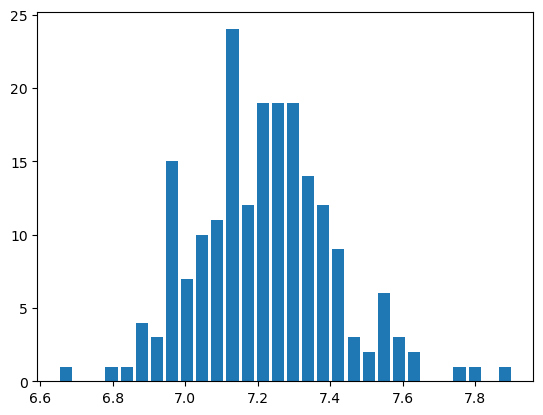

In [12]:
N = 200
sizes = [mean_cluster_size(random_grid(100, 100)) for _ in range(N)]
report(sizes)

A 100 x 100 grid isn't infinite, so let's look at larger grids:

{'mean': 7.4134560772843425,
 'max': 7.651109410864575,
 'min': 7.116171499733143,
 'stdev': 0.10453350361308941,
 'N': 200}

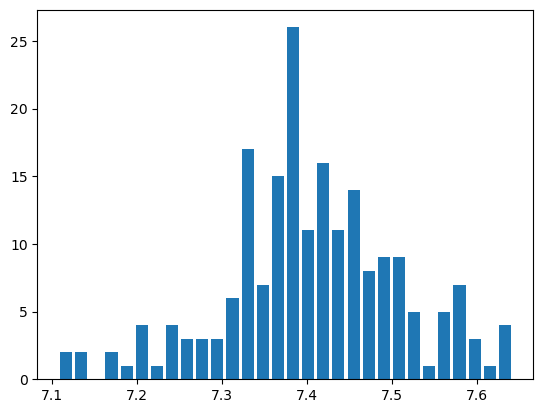

In [13]:
report([mean_cluster_size(random_grid(200, 200)) for _ in range(N)])

{'mean': 7.47612464655258,
 'max': 7.681147051292993,
 'min': 7.279786459597185,
 'stdev': 0.07889928048753433,
 'N': 200}

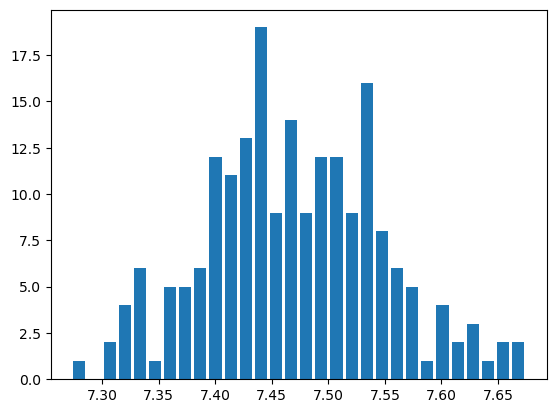

In [14]:
report([mean_cluster_size(random_grid(300, 300)) for _ in range(N)])

I think that what's happening is that the clusters that are near the edge of the grid get arbitrarily cut off, and since the edge is a smaller percentage of the larger grid, the larger grid has a larger mean cluster size, one that is a better representative of what would happen on an infinite grid. But I can't say exactly what the mean converges to.

# My First Random Cluster

The great thing about an *n* × 1 grid is that the clusters can't interfere with each other. Going left-to-right, once one cluster ends, the next one starts, and there's no looping back. But in an arbitrary 2D array there is looping back. So I want to get a feel for what the "first" cluster on an infinite grid looks like: start by placing a color at the origin square, then recursively place random colors in neighboring squares, extending the cluster, but stop when the cluster is completely surrounded by squares of the other color. 

In [15]:
def random_cluster(colors='@.', start=(0, 0)) -> Grid:
    """Create just enough of a grid to create a single random cluster."""
    cluster = {}
    Q = [start] # A queue of the frontier squares of the cluster
    while Q:
        sq = Q.pop()
        if sq not in cluster:
            cluster[sq] = random.choice(colors)
            if cluster[sq] == cluster[start]:
                Q.extend(neighbors(sq))
    return cluster

I'll define `show` to print a picture of the cluster:

In [16]:
def show(cluster: Grid) -> int:
    """Print a representation of the grid and return the size of the one cluster."""
    xs = sorted({x for (x, y) in cluster})
    ys = sorted({y for (x, y) in cluster})
    for y in ys:
        print(*[cluster.get((x, y), ' ') for x in xs])
    return cluster_size(cluster)

def cluster_size(cluster) -> int: 
    color = cluster[0, 0]
    return Counter(cluster.values())[color]

In [17]:
random.seed(37)
show(random_cluster())

  . .  
. @ @ .
. @ .  
  .    


3

In [18]:
show(random_cluster())

                                                    .    
                                                  . @ .  
                                                . @ @ .  
                                            .   . @ .    
                                          . @ . . @ .    
                                          . @ @ @ @ @ .  
                                      .   . @ @ . @ . @ .
                                  . . @ . @ @ @ @ @ @ @ .
                                . @ . @ @ @ @ @ @ . . .  
                                . @ @ @ @ . . @ .        
                              .   . @ . @ . @ .          
                        .   . @ . . . @ @ @ @ .          
                    . . @ . . @ @ @ @ @ . . .            
                  . @ @ @ @ . . @ @ . @ @ @ .            
                  . @ @ @ . .   . @ @ . @ @ . .          
              . . @ @ @ @ @ @ . @ . @ . @ @ @ @ .        
            . @ @ @ . . @ . @ @ @ @ . @ @ . . .          
              

167

In [19]:
show(random_cluster())

  . .      
. @ @ . .  
  . @ @ @ .
    . . @ .
      . @ .
        .  


7

We can see that there is a lot of variation in size and shape of the first clusters. We can also see that the shape will constrain other clusters: there are some small clusters of the second color that are trapped inside the cluster of the first color.  Below I sample 10,000 first clusters and report on their sizes:

In [20]:
sizes = [cluster_size(random_cluster()) for _ in range(10_000)]

{'mean': 59.6728, 'max': 917, 'min': 1, 'stdev': 75.3054688022268, 'N': 10000}

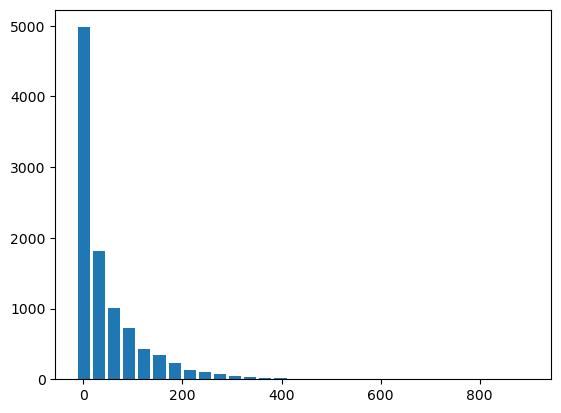

In [21]:
report(sizes)

There's quite a spread, with the standard deviation being larger than the mean, and the maximum being about 10 times the mean.  It might help to zoom in on the smaller sizes:

{'mean': 7.851026539809714,
 'max': 20,
 'min': 1,
 'stdev': 5.816812011424741,
 'N': 3994}

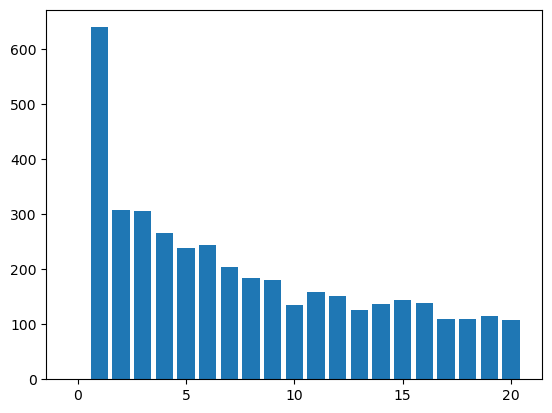

In [22]:
smaller = [s for s in sizes if s <= 20]
report(smaller, bins=range(22))

We see that there are over 600 clusters of size 1. That makes sense; we start with one square, and about once every 2<sup>4</sup> times all 4 neighbors will be the other color, and 10000 / 16 = 625.

# Tests

Some unit tests to give confidence in the code, and show examples of use:

In [23]:
assert grids(1, 3) == [
    {(0, 0): 'R', (0, 1): 'R', (0, 2): 'R'},
    {(0, 0): 'R', (0, 1): 'R', (0, 2): 'B'},
    {(0, 0): 'R', (0, 1): 'B', (0, 2): 'R'},
    {(0, 0): 'R', (0, 1): 'B', (0, 2): 'B'},
    {(0, 0): 'B', (0, 1): 'R', (0, 2): 'R'},
    {(0, 0): 'B', (0, 1): 'R', (0, 2): 'B'},
    {(0, 0): 'B', (0, 1): 'B', (0, 2): 'R'},
    {(0, 0): 'B', (0, 1): 'B', (0, 2): 'B'}]

assert grids(1, 2, 'RGB') == [
    {(0, 0): 'R', (0, 1): 'R'},
    {(0, 0): 'R', (0, 1): 'G'},
    {(0, 0): 'R', (0, 1): 'B'},
    {(0, 0): 'G', (0, 1): 'R'},
    {(0, 0): 'G', (0, 1): 'G'},
    {(0, 0): 'G', (0, 1): 'B'},
    {(0, 0): 'B', (0, 1): 'R'},
    {(0, 0): 'B', (0, 1): 'G'},
    {(0, 0): 'B', (0, 1): 'B'}]

grid6x1 = one_grid(6, 1, 'RRBBBR')
assert grid6x1 == {(0, 0): 'R', (1, 0): 'R', (2, 0): 'B', (3, 0): 'B', (4, 0): 'B', (5, 0): 'R'}
assert cluster(grid6x1) == {(0, 0): 1, (1, 0): 1, (2, 0): 2, (3, 0): 2, (4, 0): 2, (5, 0): 3}
assert mean_cluster_size(grid6x1) == 2

grid5x3 = one_grid(5, 3, 'RR:RR'
                         '.R:R.'
                         '.RRR.')
assert cluster(grid5x3) == {
    (0, 0): 1, (1, 0): 1, (2, 0): 2, (3, 0): 1, (4, 0): 1,
    (0, 1): 3, (1, 1): 1, (2, 1): 2, (3, 1): 1, (4, 1): 4,
    (0, 2): 3, (1, 2): 1, (2, 2): 1, (3, 2): 1, (4, 2): 4}
assert mean_cluster_size(grid5x3) == 3.75

grid10x2 = one_grid(10, 2, 'RBRBRRRBBR' # Example from diagram at top of notebook
                           'RRRRBBRBRB') 
assert mean_cluster_size(grid10x2) == 20/9

assert len(random_grid(3, 4)) == 12